In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import string
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer
import os
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters for BERT model and tokenization
bert_path = "bert-base-uncased"  # Use the Hugging Face model

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_path)

def get_df(file):
    return pd.read_csv(file,sep = '\t')

train_df = get_df('train_posts.txt')
test_df = get_df('test_posts.txt')

def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

tqdm.pandas()
train_df['first_image_id'] = train_df.progress_apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.progress_apply (lambda row: return_first_image(row),axis=1)

from os import listdir

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('images_train/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('images_test/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3755/3755 [00:00<00:00, 91066.12it/s]


#mBERT-base

# Image Part

In [4]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

In [5]:
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX,3,1)

# Alternatively, using from_numpy which preserves the original data type
train_imagesX = torch.from_numpy(train_imagesX).float()
test_imagesX  = torch.from_numpy(test_imagesX).float()

# The Model

In [25]:
import torch
import torch.nn as nn
from transformers import BertModel

class MBertLayer(nn.Module):
    def __init__(self, bert_path="bert-base-multilingual-cased", n_fine_tune_layers=1):
        super(MBertLayer, self).__init__()
        self.n_fine_tune_layers = n_fine_tune_layers
        self.output_size = 768  # Default output size of BERT

        # Load pre-trained mBERT model
        self.bert = BertModel.from_pretrained(bert_path)

        # Set all layers to non-trainable initially
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last `n_fine_tune_layers` layers
        if n_fine_tune_layers > 0:
            for layer in self.bert.encoder.layer[-n_fine_tune_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True

        # Optional: Linear layer to reduce dimensionality (commented for flexibility)
        # self.fc = nn.Linear(self.output_size, 256)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Get the outputs from BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True  # Ensures outputs are returned as a dictionary
        )

        # Extract the pooled output (representation of [CLS] token)
        pooled_output = outputs.pooler_output

        # Optional: Reduce dimensionality using a linear layer
        # reduced_output = self.fc(pooled_output)

        return pooled_output

# Example usage:
# mb_layer = MBertLayer(bert_path="bert-base-multilingual-cased", n_fine_tune_layers=10)

# # Example input IDs and attention mask
# input_ids = torch.tensor([[101, 2009, 2003, 1037, 3071, 102]])  # Example input
# attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]])

# output = mb_layer(input_ids=input_ids, attention_mask=attention_mask)
# print(output.shape)  # Should print torch.Size([1, 768])



In [26]:
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

# Initialize feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mb_layer = MBertLayer(bert_path="bert-base-multilingual-cased", n_fine_tune_layers=10).to(device)

# # Move input data to GPU
train_input_ids = train_input_ids.to(device)
train_input_masks = train_input_masks.to(device)
train_segment_ids = train_segment_ids.to(device)

# Move test data to GPU
# train_input_ids = test_input_ids.to(device)
# train_input_masks = test_input_masks.to(device)
# train_segment_ids = test_segment_ids.to(device)

# Process in batches with mixed precision
batch_size = 32  # Adjust based on VRAM usage
features = []

with torch.no_grad(): #, torch.cuda.amp.autocast():
    for i in tqdm(range(0, len(train_input_ids), batch_size),desc='Processing Text'):
        batch_ids = train_input_ids[i:i+batch_size]
        batch_masks = train_input_masks[i:i+batch_size]
        batch_segments = train_segment_ids[i:i+batch_size]

        batch_features = mb_layer(batch_ids, batch_masks, batch_segments)
        features.append(batch_features.cpu())  # Move to CPU to free up GPU memory

# Concatenate all batches for final output
features = torch.cat(features)
torch.save(features, "mbert_features_train.pt")
print(features.shape)



Processing Text: 100%|██████████| 446/446 [01:19<00:00,  5.61it/s]


torch.Size([14258, 768])


Only to run

In [8]:
import torch.nn as nn
from torchvision import models
# Define the main NewsModel
class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()

        text_hidden_layers = []
        input_size = 768
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ReLU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        

        vis_hidden_layers = []
        input_size = 512*7*7
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ReLU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final combined classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ReLU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
            
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self,features, image_features):
        # BERT forward pass
        #text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        
        text_output = self.text_hidden_layers(features)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = image_features
        #image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        #image_output = self.vis_hidden_layers(image_flatten)
        image_output = self.vis_hidden_layers(image_features )
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        # print(text_repr.shape)
        # print(visual_repr.shape)
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        
        return prediction

In [18]:
# params = {
#     'albert_path':"albert-base-v1",
#     'n_fine_tune_layers':1,
#     'bert_trainable' :False,
#     'text_no_hidden_layer':1,
#     'text_hidden_neurons':768,   #'text_hidden_neurons':768,
#     'dropout':0.4,
#     'repr_size':32,
#     'vis_no_hidden_layer':1,
#     'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
#     'final_no_hidden_layer':1,
#     'final_hidden_neurons':35,
#     'optimizer':['adam'],
#     'batch_size':[1],
#     'epochs':[10]
# }

In [30]:
params = {

    'text_no_hidden_layer':5,
    'text_hidden_neurons':768,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':5,
    'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':2,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
}

In [27]:

# Load saved features
features = torch.load("mbert_features_train.pt")
image_features = torch.load("image_features.pt")

import numpy as np
import torch.optim as optim
import torch.nn as nn

class LRFinder:
    def __init__(self, model, criterion=nn.BCELoss(), optimizer=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.history = {
            "lr": [],
            "loss": []
        }

    def run(self, features , image_features, labels, 
            lr):
        # Put model in training mode
        self.model.train()

        # Setup optimizer if not already provided
        if self.optimizer is None:
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Move inputs to device
        device = next(self.model.parameters()).device
        features, image_features, labels = (
            features.to(device),
            image_features.to(device),
            labels.float().to(device)
        )

        # Forward pass
        outputs = self.model(features, image_features)
        outputs = outputs.unsqueeze(1)
        loss = self.criterion(outputs.squeeze(), labels.squeeze())

        # Record the loss and learning rate
        self.history['lr'].append(lr)
        self.history['loss'].append(loss.item())

        # Perform backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Print results
        print(f"Learning Rate: {lr:.2e}, Loss: {loss.item():.4f}")

# Example usage
# Assuming you have prepared your training data: train_input_ids, train_input_masks, train_segment_ids, train_imagesX, trainY

# Create the model
model_adam = NewsModel(params).to(current_device)

# Initialize the learning rate finder
lr_finder = LRFinder(model_adam)

# Run the model with a fixed learning rate (you can set the desired learning rate here)
fixed_lr = 0.001  # Set the learning rate you want to test
lr_finder.run(features, image_features, trainY, 
               lr=fixed_lr)

# After running the model, you can visualize the results if needed


C:\Users\swaru\AppData\Local\Temp\ipykernel_25208\1047188552.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("mbert_features_train.pt")
C:\Users\sw

torch.Size([14258, 32])
torch.Size([14258, 32])
Learning Rate: 1.00e-03, Loss: 0.8504


In [31]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# Load saved features
features = torch.load("mbert_features_train.pt")
image_features = torch.load("image_features.pt")
labels = trainY

# Check the sizes of the loaded tensors
print("Features shape:", features.shape)
print("Image features shape:", image_features.shape)
print("Labels shape:", labels.shape)

# Create a dataset
dataset = TensorDataset(features, image_features, labels)

# Define the split ratio for training and validation
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Create the model
model_adam = NewsModel(params).to(current_device)

# Set the learning rate and optimizer
fixed_lr = 0.0001  # Set the desired learning rate
optimizer = optim.Adam(model_adam.parameters(), lr=fixed_lr)
criterion = nn.BCELoss()

# Training loop
num_epochs = 10  # Set the desired number of epochs
for epoch in range(num_epochs):
    model_adam.train()  # Set the model to training mode
    for batch_features, batch_image_features, batch_labels in train_loader:
        # Move inputs to device
        device = next(model_adam.parameters()).device
        batch_features, batch_image_features, batch_labels = (
            batch_features.to(device),
            batch_image_features.to(device),
            batch_labels.float().to(device)
        )

        # Forward pass
        outputs = model_adam(batch_features, batch_image_features)
        outputs = outputs.unsqueeze(1)
        loss = criterion(outputs.squeeze(), batch_labels.squeeze())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model_adam.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradient tracking for validation
        for val_features, val_image_features, val_labels in val_loader:
            val_features, val_image_features, val_labels = (
                val_features.to(device),
                val_image_features.to(device),
                val_labels.float().to(device)
            )

            # Forward pass
            val_outputs = model_adam(val_features, val_image_features)
            val_outputs = val_outputs.unsqueeze(1)
            val_loss += criterion(val_outputs.squeeze(), val_labels.squeeze()).item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    
    # Print results for the current epoch
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}")

#After the training loop, you can save the model or perform evaluation as needed


C:\Users\swaru\AppData\Local\Temp\ipykernel_25208\2889701457.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("mbert_features_train.pt")
C:\Users\sw

Features shape: torch.Size([14258, 768])
Image features shape: torch.Size([14258, 25088])
Labels shape: torch.Size([14258, 1])
Epoch: 1/10, Loss: 0.0281, Val Loss: 0.0237
Epoch: 2/10, Loss: 0.0041, Val Loss: 0.0205
Epoch: 3/10, Loss: 0.0332, Val Loss: 0.0353
Epoch: 4/10, Loss: 0.0008, Val Loss: 0.0364
Epoch: 5/10, Loss: 0.0017, Val Loss: 0.0456
Epoch: 6/10, Loss: 0.0033, Val Loss: 0.0375
Epoch: 7/10, Loss: 0.0023, Val Loss: 0.0553
Epoch: 8/10, Loss: 0.0147, Val Loss: 0.0657
Epoch: 9/10, Loss: 0.0069, Val Loss: 0.1077
Epoch: 10/10, Loss: 0.0019, Val Loss: 0.0716


In [9]:
#provide good result for mBert

params = {

    'text_no_hidden_layer':2,
    'text_hidden_neurons':768,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':2,
    'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':7,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
}

C:\Users\swaru\AppData\Local\Temp\ipykernel_25208\2391065530.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("mbert_features_train.pt")
C:\Users\sw

Features shape: torch.Size([14258, 768])
Image features shape: torch.Size([14258, 25088])
Labels shape: torch.Size([14258, 1])
Epoch: 1/20, Loss: 0.2707, Val Loss: 0.2534
Epoch: 2/20, Loss: 0.2252, Val Loss: 0.2344
Epoch: 3/20, Loss: 0.2606, Val Loss: 0.2000
Epoch: 4/20, Loss: 0.1558, Val Loss: 0.1591
Epoch: 5/20, Loss: 0.1099, Val Loss: 0.1281
Epoch: 6/20, Loss: 0.0647, Val Loss: 0.0971
Epoch: 7/20, Loss: 0.0657, Val Loss: 0.0467
Epoch: 8/20, Loss: 0.0550, Val Loss: 0.0728
Epoch: 9/20, Loss: 0.0214, Val Loss: 0.1122
Epoch: 10/20, Loss: 0.0450, Val Loss: 0.0688
Epoch: 11/20, Loss: 0.1147, Val Loss: 0.0668
Epoch: 12/20, Loss: 0.0417, Val Loss: 0.0687
Epoch: 13/20, Loss: 0.0230, Val Loss: 0.1370
Epoch: 14/20, Loss: 0.0597, Val Loss: 0.1253
Epoch: 15/20, Loss: 0.0750, Val Loss: 0.1312
Epoch: 16/20, Loss: 0.0527, Val Loss: 0.1052
Epoch: 17/20, Loss: 0.0174, Val Loss: 0.1992
Epoch: 18/20, Loss: 0.0631, Val Loss: 0.1575
Epoch: 19/20, Loss: 0.0150, Val Loss: 0.0945
Epoch: 20/20, Loss: 0.0190,

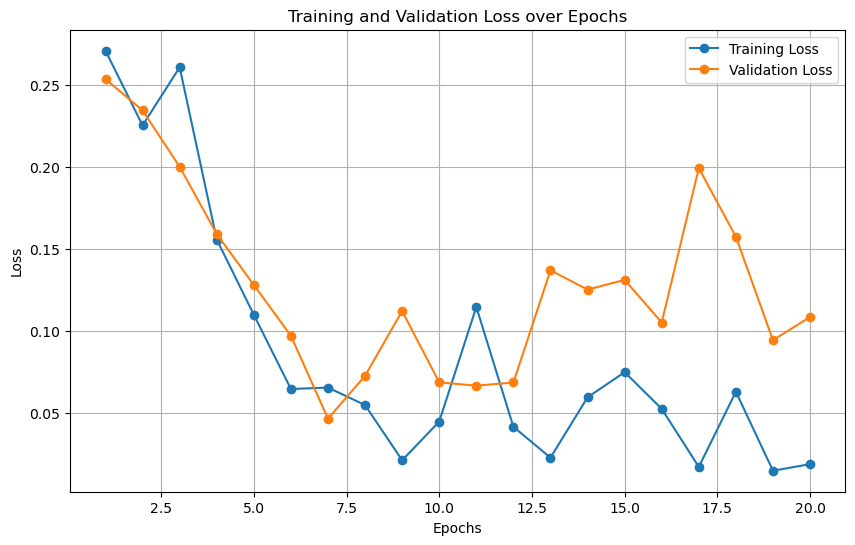

In [37]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

# Load saved features
features = torch.load("mbert_features_train.pt")
image_features = torch.load("image_features.pt")
labels = trainY

# Check the sizes of the loaded tensors
print("Features shape:", features.shape)
print("Image features shape:", image_features.shape)
print("Labels shape:", labels.shape)

# Create a dataset
dataset = TensorDataset(features, image_features, labels)

# Define the split ratio for training and validation
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Create the model
model_adam = NewsModel(params).to(current_device)

# Set the learning rate and optimizer
fixed_lr = 0.001  # Set the desired learning rate
optimizer = optim.Adam(model_adam.parameters(), lr=fixed_lr)
criterion = nn.BCELoss()
train_losses = []
val_losses = []
# Training loop
num_epochs = 20  # Set the desired number of epochs
for epoch in range(num_epochs):
    model_adam.train()  # Set the model to training mode
    for batch_features, batch_image_features, batch_labels in train_loader:
        # Move inputs to device
        device = next(model_adam.parameters()).device
        batch_features, batch_image_features, batch_labels = (
            batch_features.to(device),
            batch_image_features.to(device),
            batch_labels.float().to(device)
        )

        # Forward pass
        outputs = model_adam(batch_features, batch_image_features)
        outputs = outputs.unsqueeze(1)
        loss = criterion(outputs.squeeze(), batch_labels.squeeze())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model_adam.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradient tracking for validation
        for val_features, val_image_features, val_labels in val_loader:
            val_features, val_image_features, val_labels = (
                val_features.to(device),
                val_image_features.to(device),
                val_labels.float().to(device)
            )

            # Forward pass
            val_outputs = model_adam(val_features, val_image_features)
            val_outputs = val_outputs.unsqueeze(1)
            val_loss += criterion(val_outputs.squeeze(), val_labels.squeeze()).item()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    
    # Print results for the current epoch
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}")
    train_losses.append(loss.item())
    val_losses.append(avg_val_loss)

#After the training loop, you can save the model or perform evaluation as needed

# Optionally, visualize the losses later
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), np.array(train_losses), label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1),np.array(val_losses), label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


#Save model

In [39]:
torch.save(model_adam, 'model_complete_updated.pth')
# Load the entire model
#model = torch.load('model_complete.pth')

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load saved features
test_features = torch.load("mbert_features_test.pt")
test_image_features = torch.load("image_features_test.pt")
test_labels = testY  # Assuming testY is defined elsewhere

# Create a test dataset and dataloader
test_dataset = TensorDataset(test_features, test_image_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#model_adam=model
# Set the model to evaluation mode
model_adam.eval()
test_loss = 0.0
criterion = nn.BCELoss()  # Using the same loss function as in training

# Initialize metrics
total_samples = 0

# Initialize accumulators for overall metrics
all_true_labels = []
all_predicted_labels = []
test_loss = 0.0  # Resetting test_loss to use for averaging later

with torch.no_grad():  # Disable gradient calculations for testing
    for features, image_features, labels in test_loader:
        # Move inputs to device
        features, image_features, labels = (
            features.to(device),
            image_features.to(device),
            labels.float().to(device)  # Ensure labels are floats for BCELoss
        )

        # Forward pass
        outputs = model_adam(features, image_features)
        outputs = outputs.unsqueeze(1)  # Adjusting dimensions if needed
        
        # Calculate the batch test loss
        loss = criterion(outputs.squeeze(), labels.squeeze())
        test_loss += loss.item()  # Accumulate loss
        total_samples += labels.size(0)  # Count total samples

        # Convert probabilities to binary predictions (assuming output is in [0, 1])
        predicted_labels = (outputs.squeeze().cpu().numpy() > 0.5).astype(int)  # Apply threshold
        true_labels = labels.squeeze().cpu().numpy()  # Use correct variable name

        # Store the true and predicted labels for overall metrics
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

# Convert to numpy arrays for metric calculations
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate overall metrics
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')

# Calculate the average test loss
avg_test_loss = test_loss / len(test_loader)  # This gives you the average loss per batch

# Print overall metrics
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")


C:\Users\swaru\AppData\Local\Temp\ipykernel_25208\4254019965.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_features = torch.load("mbert_features_test.pt")
C:\User

Average Test Loss: 0.8827
Overall Accuracy: 0.7618
Overall Precision: 0.7249
Overall Recall: 1.0000
Overall F1 Score: 0.8405


In [9]:
# Load the entire model
model_adam = torch.load('model_complete_updated.pth')

C:\Users\swaru\AppData\Local\Temp\ipykernel_25464\1772260156.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_adam = torch.load('model_complete_updated.pth')


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load saved features
test_features = torch.load("mbert_features_test.pt")
test_image_features = torch.load("image_features_test.pt")
test_labels = testY  # Assuming testY is defined elsewhere
device = current_device
# Create a test dataset and dataloader
test_dataset = TensorDataset(test_features, test_image_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#model_adam=model
# Set the model to evaluation mode
model_adam.eval()
test_loss = 0.0
criterion = nn.BCELoss()  # Using the same loss function as in training

# Initialize metrics
total_samples = 0

# Initialize accumulators for overall metrics
all_true_labels = []
all_predicted_labels = []
test_loss = 0.0  # Resetting test_loss to use for averaging later

with torch.no_grad():  # Disable gradient calculations for testing
    for features, image_features, labels in test_loader:
        # Move inputs to device
        features, image_features, labels = (
            features.to(device),
            image_features.to(device),
            labels.float().to(device)  # Ensure labels are floats for BCELoss
        )

        # Forward pass
        outputs = model_adam(features, image_features)
        outputs = outputs.unsqueeze(1)  # Adjusting dimensions if needed
        
        # Calculate the batch test loss
        loss = criterion(outputs.squeeze(), labels.squeeze())
        test_loss += loss.item()  # Accumulate loss
        total_samples += labels.size(0)  # Count total samples

        # Convert probabilities to binary predictions (assuming output is in [0, 1])
        predicted_labels = (outputs.squeeze().cpu().numpy() > 0.5).astype(int)  # Apply threshold
        true_labels = labels.squeeze().cpu().numpy()  # Use correct variable name

        # Store the true and predicted labels for overall metrics
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

# Convert to numpy arrays for metric calculations
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate overall metrics
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')

# Calculate the average test loss
avg_test_loss = test_loss / len(test_loader)  # This gives you the average loss per batch

# Print overall metrics
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1 Score: {f1:.4f}")


C:\Users\swaru\AppData\Local\Temp\ipykernel_25464\900137593.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_features = torch.load("mbert_features_test.pt")
C:\Users

Average Test Loss: 0.8827
Overall Accuracy: 0.7618
Overall Precision: 0.7249
Overall Recall: 1.0000
Overall F1 Score: 0.8405


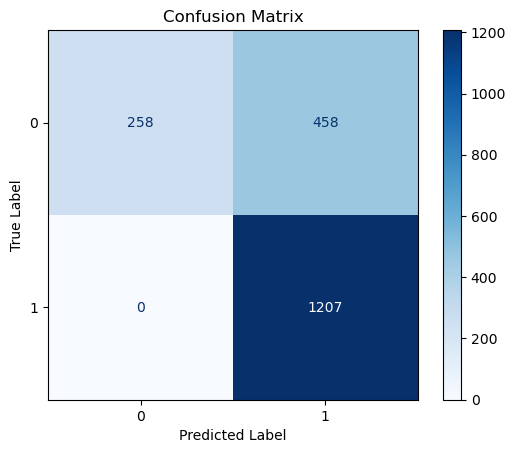

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


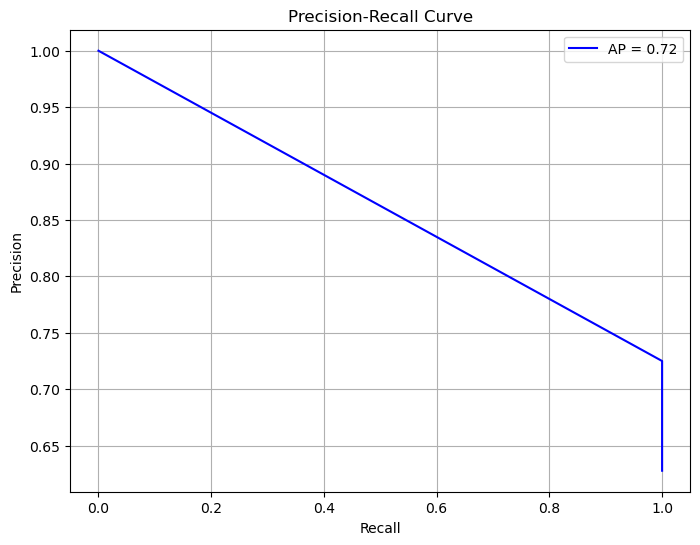

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(all_true_labels, all_predicted_labels)

# Calculate Average Precision (AP) score
average_precision = average_precision_score(all_true_labels, all_predicted_labels)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='b')

# Add plot details
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid()
plt.show()
